# Energy consumption analysis

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from itertools import groupby

In [9]:
column_names = ["bus_voltage", "shunt_voltage", "load_voltage", "curr_mA", "pwr_mW", "discrete"]

class ExperimentsSuite:
    def __init__(self, data_dir: str):
        runs = os.listdir('./output')
        print(runs)
        self.experiments = {name[:-4]: (lambda x : x.loc[x.discrete == 1])(pd.read_csv(f'./output/{name}', header=0, names=column_names)) for name in runs}

    @staticmethod
    def _group_models(experiments):
        groups = {key: [] for key in set([experiment[2:] for experiment in experiments])} 
        for experiment in experiments:
            groups[experiment[2:]].append(experiment)
        return groups

    def plot_experiments(self, metric, mu):
        key_map = {'P0': 'Sem T800', 'P1': 'DT-10', 'P2': 'DT-12', 'P3': 'MLP'}
        groupped_models = ExperimentsSuite._group_models(self.experiments.keys())
        subplots = [plt.subplots(1, 1, figsize=(6, 4)) for _ in groupped_models]
        figs, axis = list(zip(*subplots))
        for ax, group in zip(axis, groupped_models):
            names, points = list(zip(*[(exp[:2], np.ravel(self.experiments[exp][metric])) for exp in groupped_models[group]]))
            ax.violinplot(points, list(range(len(points))), showmedians=True)
            ax.set_xticks(list(range(len(names))))
            ax.set_xticklabels([key_map[name] for name in names])
            ax.set_xlabel('Models', fontsize=12)
            ax.set_ylabel(mu, fontsize=12)
            ax.set_title(group, fontsize=30)
            ax.tick_params(axis='x', labelsize=10)
            ax.grid(color='gainsboro', linestyle=':', linewidth=2)
        return {name: fig for name, fig in zip(groupped_models, figs)}
    
    def get_factors_importance(self, model):
        levels = ['A0I1M0', 'A0I1M1', 'A0I2M0', 'A0I2M1', f'A{model}I1M0', f'A{model}I1M1', f'A{model}I2M0', f'A{model}I2M1']
        encoded_A_levels = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
        encoded_I_levels = np.array([-1, -1, 1, 1, -1, -1, 1, 1])
        encoded_M_levels = np.array([1, -1, 1, -1, 1, -1, 1, -1])
        first_column = np.ones_like(encoded_I_levels)
        second_column = encoded_A_levels
        third_column = encoded_I_levels
        fourth_column = encoded_M_levels
        fith_column = encoded_A_levels * encoded_I_levels
        sixth_column = encoded_A_levels * encoded_M_levels
        seventh_column = encoded_I_levels * encoded_M_levels
        eigth_column = encoded_A_levels * encoded_I_levels * encoded_M_levels
        X = np.stack([first_column, second_column, third_column, fourth_column, fith_column, sixth_column, seventh_column, eigth_column], axis=1)
        
        cpu_series = np.array([self.experiments[level].get_time_series('CPU') for level in levels])
        cpu_vals = np.mean(cpu_series[:,150:,:], axis=1)
        mean_cpus = np.mean(cpu_vals, axis=-1)
        system_solutions = np.linalg.solve(X, mean_cpus)
        errors = cpu_vals - np.expand_dims(mean_cpus, axis=-1)
        squared_errors = np.square(errors)
        squared_system_solutions = np.square(system_solutions)
        squared_cpus = np.square(cpu_vals)
        SSY = np.sum(squared_cpus)
        SSE = np.sum(squared_errors)
        SSqs = 8 * 10 * squared_system_solutions
        SST = SSY - SSqs[0]
        
        importances = (np.concatenate([SSqs[1:], np.expand_dims(SSE, axis=0)]) / np.expand_dims(SST, axis=0)).T
        return importances

In [10]:
experiments_suite = ExperimentsSuite('./output')

['P0I1M0.csv', 'P0I1M1.csv', 'P0I2M0.csv', 'P0I2M1.csv', 'P1I1M0.csv', 'P1I1M1.csv', 'P1I2M0.csv', 'P1I2M1.csv', 'P2I1M0.csv', 'P2I1M1.csv', 'P2I2M0.csv', 'P2I2M1.csv', 'P3I1M0.csv', 'P3I1M1.csv', 'P3I2M0.csv', 'P3I2M1.csv']


## Energy consumption plots

In [13]:
groupped_models = ExperimentsSuite._group_models(experiments_suite.experiments.keys())
names, pwr = list(zip(*[(exp, np.ravel(experiments_suite.experiments[exp]['pwr_mW'].values),\
                                                    ) for exp in experiments_suite.experiments]))
for name, x, in zip(names, pwr):
    print(f'{name} & {np.round_(np.median(x), 2)}\\\\')

P0I1M0 & 404.0\\
P0I1M1 & 528.0\\
P0I2M0 & 404.0\\
P0I2M1 & 448.0\\
P1I1M0 & 404.0\\
P1I1M1 & 174.0\\
P1I2M0 & 400.0\\
P1I2M1 & 404.0\\
P2I1M0 & 174.0\\
P2I1M1 & 404.0\\
P2I2M0 & 404.0\\
P2I2M1 & 176.0\\
P3I1M0 & 406.0\\
P3I1M1 & 412.0\\
P3I2M0 & 400.0\\
P3I2M1 & 400.0\\


['P0I1M0.csv', 'P0I1M1.csv', 'P0I2M0.csv', 'P0I2M1.csv', 'P1I1M0.csv', 'P1I1M1.csv', 'P1I2M0.csv', 'P1I2M1.csv', 'P2I1M0.csv', 'P2I1M1.csv', 'P2I2M0.csv', 'P2I2M1.csv', 'P3I1M0.csv', 'P3I1M1.csv', 'P3I2M0.csv', 'P3I2M1.csv']


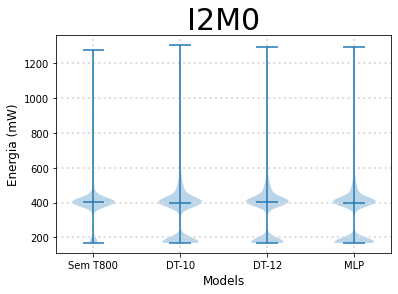

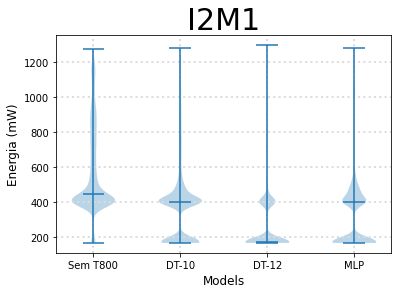

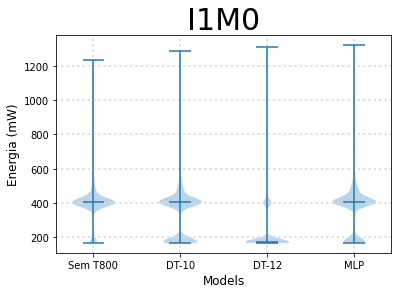

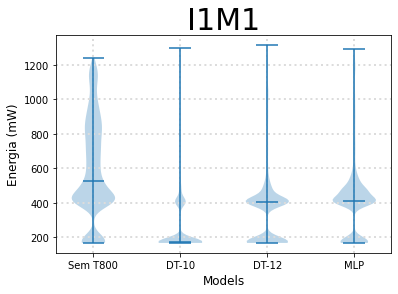

In [ ]:
figs = experiments_suite.plot_experiments('pwr_mW', 'Energia (mW)')
for fig in figs:
    figs[fig].savefig(f'./figs/{fig}_pwr_mW.pdf')